In [1]:
import argparse
import gc
import logging
import os

import sys
# sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')


import time

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

from sgan.data.loader import data_loader
from sgan.losses_argo import gan_g_loss, gan_d_loss, l2_loss
from sgan.losses_argo import displacement_error, final_displacement_error

from sgan.models_argo import TrajectoryGenerator, TrajectoryDiscriminator
from sgan.utils import int_tuple, bool_flag, get_total_norm
from sgan.utils import relative_to_abs, get_dset_path

from sgan.data.data import Argoverse_Social_Data, collate_traj_social
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import numpy as np
torch.backends.cudnn.benchmark = True

from matplotlib import pyplot as plt

from matplotlib import pyplot as plt
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

In [2]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight)
        
def get_dtypes(use_gpu=True):
    long_dtype = torch.LongTensor
    float_dtype = torch.FloatTensor
    if use_gpu == 1:
        long_dtype = torch.cuda.LongTensor
        float_dtype = torch.cuda.FloatTensor
    return long_dtype, float_dtype        

In [3]:
def relativeToAbsolute(traj, R, t):    
    seq_len = traj.shape[0] 
    traj = np.reshape(traj, (-1, 2))
    
    traj = np.swapaxes(traj, 1, 0)
    traj = np.matmul(R.T,traj)
    traj = np.swapaxes(traj, 1, 0)
    traj = traj + t
    traj = np.reshape(traj, (seq_len, -1, 2))
    return traj

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
long_dtype, float_dtype = get_dtypes()

argoverse_val   = Argoverse_Social_Data('../../deep_prediction/data/val/data')
argoverse_test  = Argoverse_Social_Data('../../deep_prediction/data/test_obs/data')
# sample_data  = Argoverse_Social_Data('../forecasting_sample/data')

In [5]:
batch_size = 32
val_loader = DataLoader(argoverse_val, batch_size=batch_size,
                    shuffle=True, num_workers=2,collate_fn=collate_traj_social)
test_loader = DataLoader(argoverse_test, batch_size=1,
                    shuffle=False, num_workers=2,collate_fn=collate_traj_social)
# sample_loader = DataLoader(sample_data, batch_size=batch_size,
#                 shuffle=True, num_workers=2,collate_fn=collate_traj_social)

In [6]:
generator = TrajectoryGenerator(
    obs_len=20,
    pred_len=30,
    embedding_dim=16,
    encoder_h_dim=32,
    decoder_h_dim=32,
    mlp_dim=64,
    num_layers=1,
    noise_dim=(8, ),
    noise_type='gaussian',
    noise_mix_type='global',
    pooling_type='pool_net',
    pool_every_timestep=0,
    dropout=0,
    bottleneck_dim=32,
    neighborhood_size=2.0,
    grid_size=8,
    batch_norm=False)

generator.apply(init_weights)
generator.type(float_dtype).train()

TrajectoryGenerator(
  (encoder): Encoder(
    (encoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
    (hidden2pos): Linear(in_features=32, out_features=2, bias=True)
  )
  (pool_net): PoolHiddenNet(
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
    (mlp_pre_pool): Sequential(
      (0): Linear(in_features=48, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=32, bias=True)
      (3): ReLU()
    )
  )
  (mlp_decoder_context): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24, bias=True)
    (3): ReLU()
  )
)

In [7]:
# output_dir = os.getcwd()
# checkpoint_name = 'gan_test'
# restore_path = os.path.join(output_dir,'%s_with_model.pt' % checkpoint_name)
restore_path = '../saved_model/03-05-2020/gan_test_with_model.pt'
checkpoint = torch.load(restore_path)
generator.load_state_dict(checkpoint['g_state'])

<All keys matched successfully>

In [8]:
def poly_fit(traj, traj_len=30, threshold=0.002):
    """
    Input:
    - traj: Numpy array of shape (2, traj_len)
    - traj_len: Len of trajectory
    - threshold: Minimum error to be considered for non linear traj
    Output:
    - int: 1 -> Non Linear 0-> Linear
    """
    t = np.linspace(0, traj_len - 1, traj_len)
    res_x = np.polyfit(t, traj[:, 0], 2, full=True)[1]
    res_y = np.polyfit(t, traj[:, 1], 2, full=True)[1]
    
    if res_x + res_y >= threshold:
        return 1.0
    else:
        return 0.0

In [9]:
dataiter = iter(val_loader)
batch = dataiter.next()

train_agent = batch['train_agent']
gt_agent = batch['gt_agent']
neighbour = batch['neighbour']
neighbour_gt = batch['neighbour_gt']
av = batch['av']
av_gt = batch['av_gt']
seq_path = batch['seq_path']
seq_id = batch['indexes']
Rs = batch['rotation']
ts = batch['translation']

obs_traj = train_agent[0].unsqueeze(0)
obs_traj = torch.cat((obs_traj, av[0].unsqueeze(0)),0)
obs_traj = torch.cat((obs_traj, neighbour[0]),0)

pred_traj_gt = gt_agent[0].unsqueeze(0)
pred_traj_gt = torch.cat((pred_traj_gt, av_gt[0].unsqueeze(0)),0)
pred_traj_gt = torch.cat((pred_traj_gt, neighbour_gt[0]),0)

ped_count = obs_traj.shape[0]
seq_start_end = [[0, ped_count]] # last number excluded

non_linear_ped = []
_non_linear_ped = [poly_fit(np.array(gt_agent[0]))]
_non_linear_ped.append(poly_fit(np.array(av_gt[0])))

for j in range(ped_count-2):
    _non_linear_ped.append(poly_fit(np.array(neighbour_gt[0][j])))
non_linear_ped += _non_linear_ped

for i in range(1, len(neighbour)):
    obs_traj = torch.cat((obs_traj, train_agent[i].unsqueeze(0)), 0)
    obs_traj = torch.cat((obs_traj, av[i].unsqueeze(0)),0)
    obs_traj = torch.cat((obs_traj, neighbour[i]), 0)

    pred_traj_gt = torch.cat((pred_traj_gt, gt_agent[i].unsqueeze(0)), 0)
    pred_traj_gt = torch.cat((pred_traj_gt, av_gt[i].unsqueeze(0)),0)
    pred_traj_gt = torch.cat((pred_traj_gt, neighbour_gt[i]), 0)

    seq_start_end.append([ped_count, obs_traj.shape[0]])

    num_peds_considered = obs_traj.shape[0] - ped_count
    ped_count = obs_traj.shape[0]

    _non_linear_ped = [poly_fit(np.array(gt_agent[i]))]
    _non_linear_ped.append(poly_fit(np.array(av_gt[i])))
    
    for j in range(num_peds_considered-2):
        _non_linear_ped.append(poly_fit(np.array(neighbour_gt[i][j])))

    non_linear_ped += _non_linear_ped

obs_traj_rel = torch.zeros(obs_traj.shape)
obs_traj_rel[:,1:,:] = obs_traj[:,1:,:] -  obs_traj[:,:-1,:]    

pred_traj_gt_rel = torch.zeros(pred_traj_gt.shape)
pred_traj_gt_rel[:,1:,:] = pred_traj_gt[:,1:,:] - pred_traj_gt[:,0:-1,:]

seq_start_end = torch.tensor(seq_start_end)
non_linear_ped = torch.tensor(non_linear_ped).cuda()

## 
obs_traj = obs_traj.transpose_(0,1).cuda() 
obs_traj_rel = obs_traj_rel.transpose_(0,1).cuda() 
pred_traj_gt = pred_traj_gt.transpose_(0,1).cuda() 
pred_traj_gt_rel = pred_traj_gt_rel.transpose_(0,1).cuda() 

################################################################

linear_ped = 1 - non_linear_ped

loss_mask = torch.ones(pred_traj_gt.shape[1],30).cuda()

pred_traj_fake_rel = generator(obs_traj, obs_traj_rel, seq_start_end)
pred_traj_fake = relative_to_abs(pred_traj_fake_rel, obs_traj[-1])

# Get data to CPU
obs_traj_ = np.array(obs_traj.cpu())
pred_traj_gt_ = np.array(pred_traj_gt.cpu())
pred_traj_fake_ = pred_traj_fake.cpu().detach().numpy()

In [10]:
def plot_seq(seq_num):
    start = seq_start_end[seq_num][0] # agent idx in seq_list
    end = seq_start_end[seq_num][1] # agent idx in seq_list

    seq_len = end - start

    city = batch['city_name'][seq_num]
    seq_id_ = seq_id[seq_num]
    seq_lane_props = avm.city_lane_centerlines_dict[city]
    
    R = Rs[seq_num]
    t = ts[seq_num]
    
    obs_traj_[:,start+1:end,:] = obs_traj_[:,start+1:end,:] + np.expand_dims(obs_traj_[:,start,:], axis=1)
    pred_traj_gt_[:,start+1:end,:] = pred_traj_gt_[:,start+1:end,:] + np.expand_dims(pred_traj_gt_[:,start,:], axis=1)
    pred_traj_fake_[:,start+1:end,:] = pred_traj_fake_[:,start+1:end,:] + np.expand_dims(pred_traj_fake_[:,start,:], axis=1)
    
    obs_traj_abs = relativeToAbsolute(obs_traj_[:,start:end,:], R, t)
    pred_traj_gt_abs = relativeToAbsolute(pred_traj_gt_[:,start:end,:], R, t)
    pred_traj_fake_abs = relativeToAbsolute(pred_traj_fake_[:,start:end,:], R, t)

    x_min = np.min(np.concatenate((obs_traj_abs[:,:seq_len,0], pred_traj_gt_abs[:,:seq_len,0], pred_traj_fake_abs[:,:seq_len,0]),axis=0))
    x_max = np.max(np.concatenate((obs_traj_abs[:,:seq_len,0], pred_traj_gt_abs[:,:seq_len,0], pred_traj_fake_abs[:,:seq_len,0]),axis=0))
    y_min = np.min(np.concatenate((obs_traj_abs[:,:seq_len,1], pred_traj_gt_abs[:,:seq_len,1], pred_traj_fake_abs[:,:seq_len,1]),axis=0))
    y_max = np.max(np.concatenate((obs_traj_abs[:,:seq_len,1], pred_traj_gt_abs[:,:seq_len,1], pred_traj_fake_abs[:,:seq_len,1]),axis=0))
    
    plt.figure(0, figsize=(8, 7))

    lane_centerlines = []

    # Get lane centerlines which lie within the range of trajectories
    for lane_id, lane_props in seq_lane_props.items():
        lane_cl = lane_props.centerline

        if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
            lane_centerlines.append(lane_cl)

    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)

    # plot obsvervation trajectory

    obsv_color = "#ECA154"
    target_color = "#d33e4c"
    pred_color = "#007672"
    others_color = "#89D4F5"
    av_color = "#D12396"
    
    ## Others
    plt.plot(
        obs_traj_abs[:,2:seq_len,0],
        obs_traj_abs[:,2:seq_len,1],
        color=others_color,
        alpha=0.5,
        linewidth=3,
        zorder=15,
    )

    plt.plot(
        pred_traj_gt_abs[:,2:seq_len,0],
        pred_traj_gt_abs[:,2:seq_len,1],
        color=others_color,
        alpha=0.5,
        linewidth=3,
        zorder=15,
    )

    plt.plot(
        pred_traj_gt_abs[-1,2:seq_len,0],
        pred_traj_gt_abs[-1,2:seq_len,1],
        "o",
        color="#C3A2D6",
        alpha=0.8,
        linewidth=3,
        zorder=15,
        markersize=9
    )
    
    ## AV
    plt.plot(
        obs_traj_abs[:,1,0],
        obs_traj_abs[:,1,1],
        color=av_color,
        alpha=0.5,
        label="AV agent",
        linewidth=3,
        zorder=15,
    )

    plt.plot(
        pred_traj_gt_abs[:,1,0],
        pred_traj_gt_abs[:,1,1],
        color=av_color,
        alpha=0.5,
        linewidth=3,
        zorder=15,
    )

    plt.plot(
        pred_traj_gt_abs[-1,1,0],
        pred_traj_gt_abs[-1,1,1],
        "o",
        color=av_color,
        alpha=0.8,
        linewidth=3,
        zorder=15,
        markersize=9
    )    
    
    plt.plot(
        obs_traj_abs[:,0,0],
        obs_traj_abs[:,0,1],
        color= obsv_color,
        label="Observed",
        alpha=1,
        linewidth=3,
        zorder=15,
    )

    plt.plot(
        obs_traj_abs[-1,0,0],
        obs_traj_abs[-1,0,1],
        "o",
        color=obsv_color,
        alpha=1,
        linewidth=3,
        zorder=15,
        markersize=9,
    )

    plt.plot(
        pred_traj_gt_abs[:,0,0],
        pred_traj_gt_abs[:,0,1],
        color=target_color,
        label="Target",
        alpha=0.8,
        linewidth=3,
        zorder=20,
    )

    plt.plot(
        pred_traj_gt_abs[-1,0,0],
        pred_traj_gt_abs[-1,0,1],
        "o",
        color=target_color,
        alpha=1,
        linewidth=3,
        zorder=20,
        markersize=9
    )

    plt.plot(
        pred_traj_fake_abs[:,0,0],
        pred_traj_fake_abs[:,0,1],
        color=pred_color,
        label="Prediction",
        alpha=1,
        linewidth=3,
        zorder=15,
    )

    plt.plot(
        pred_traj_fake_abs[-1,0,0],
        pred_traj_fake_abs[-1,0,1],
        "o",
        color=pred_color,
        alpha=1,
        linewidth=3,
        zorder=15,
        markersize=9
    )

    plt.legend()
    plt.show()    

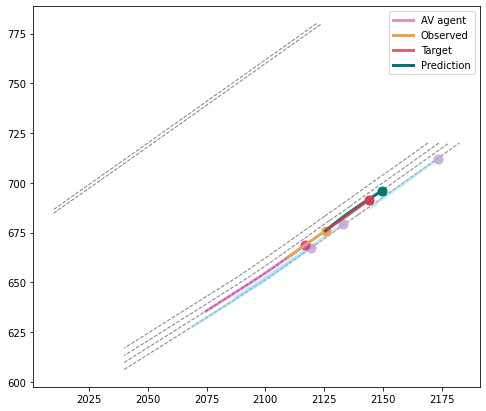

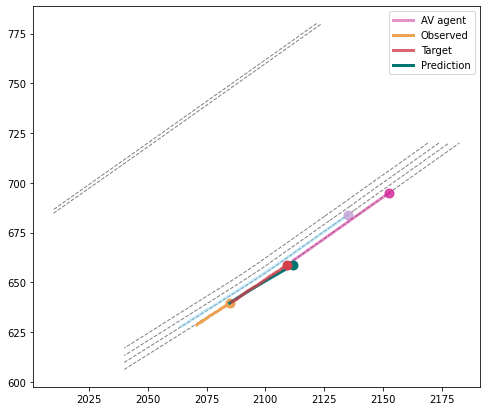

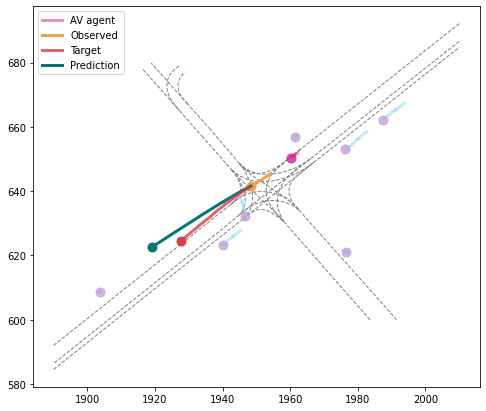

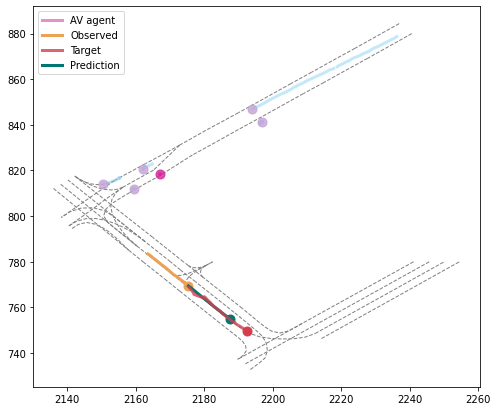

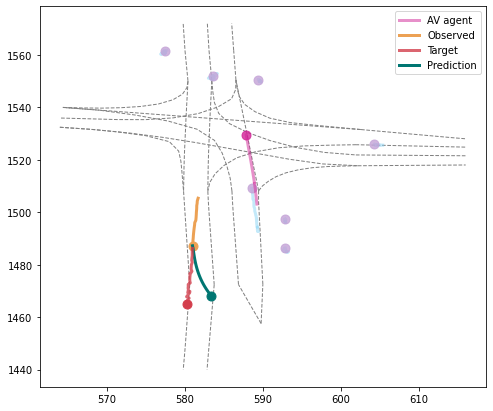

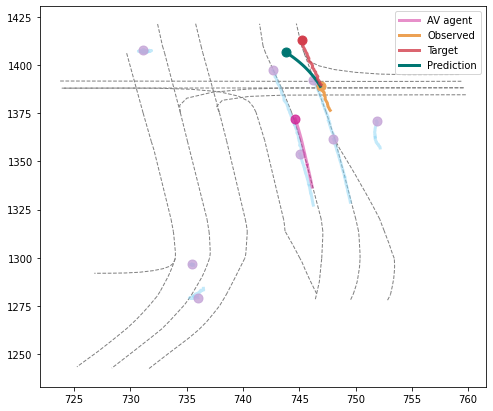

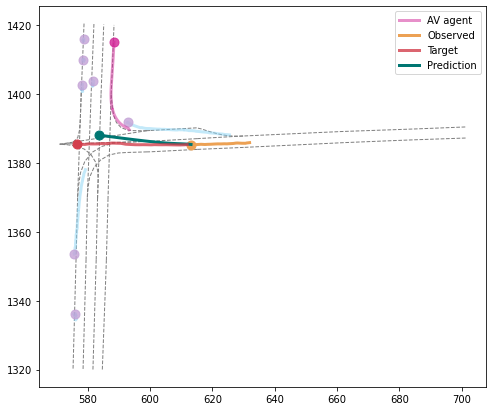

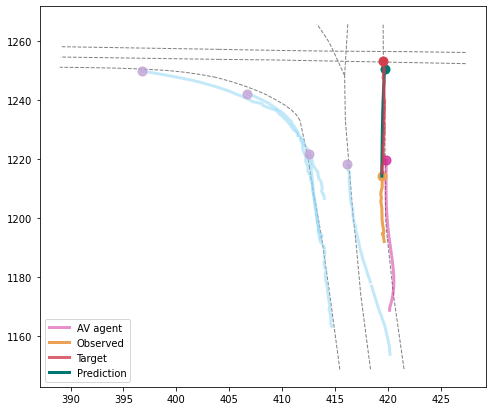

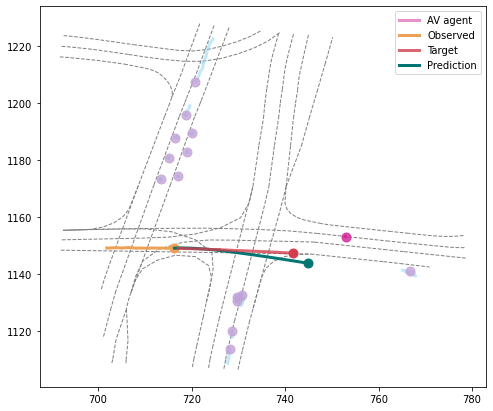

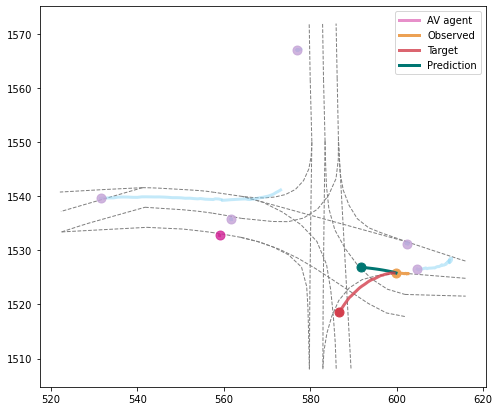

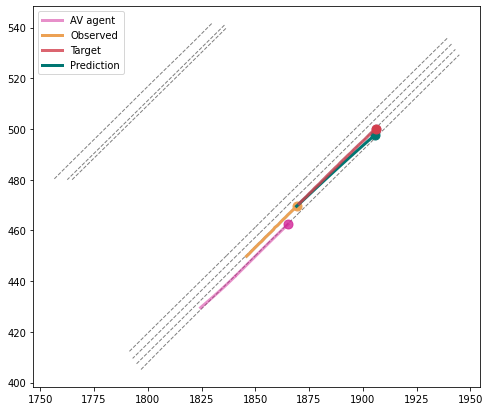

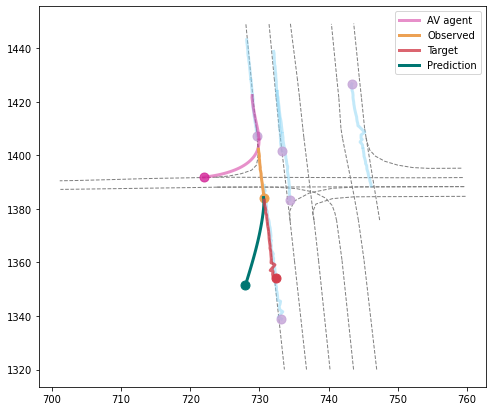

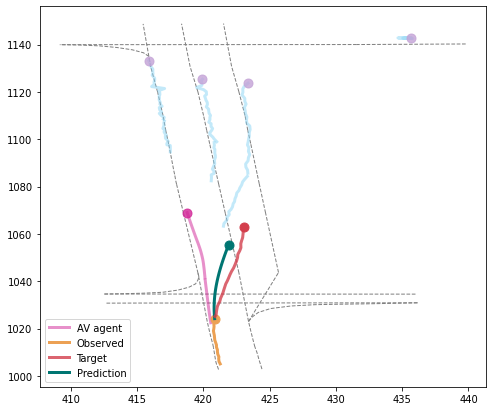

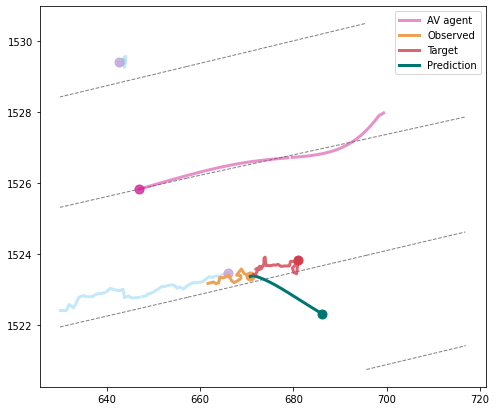

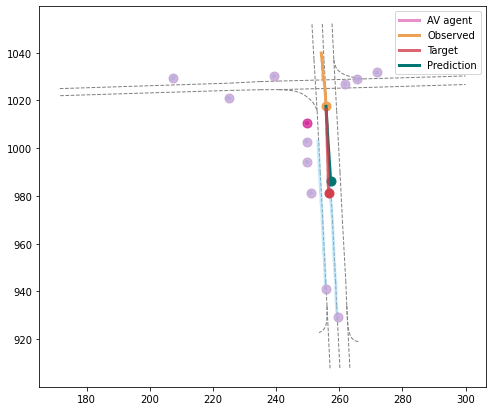

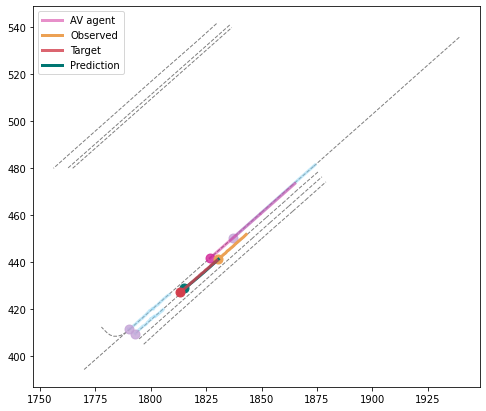

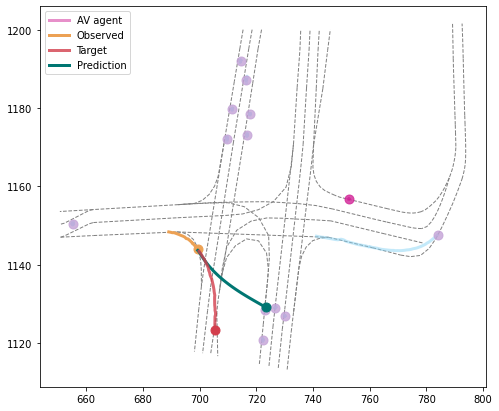

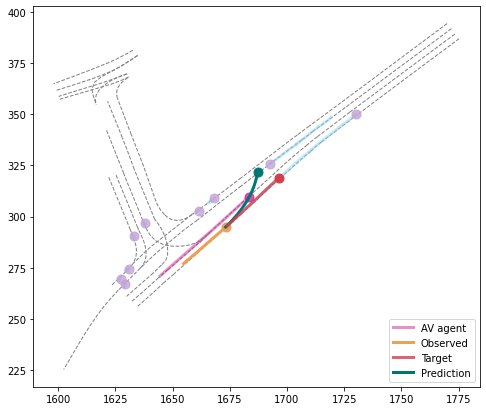

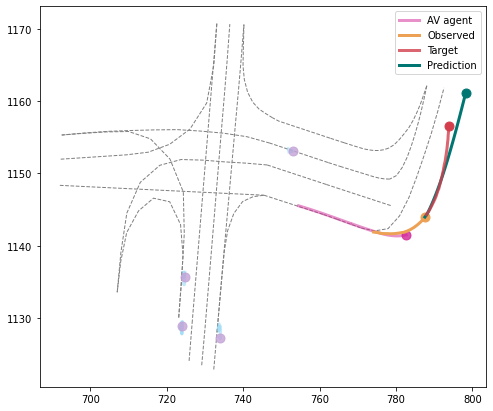

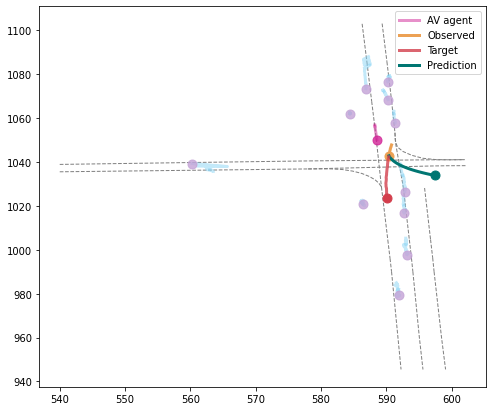

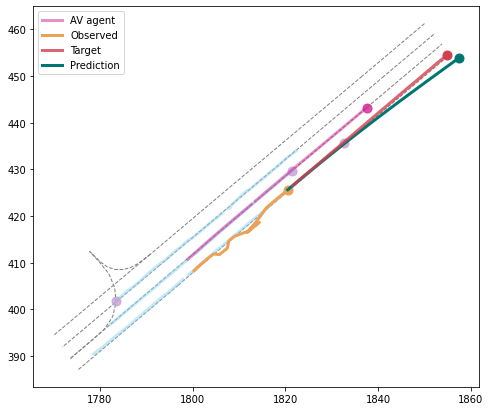

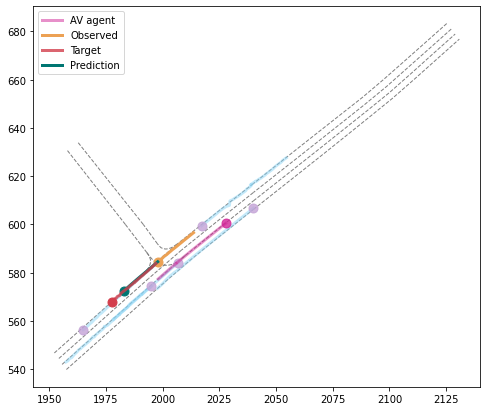

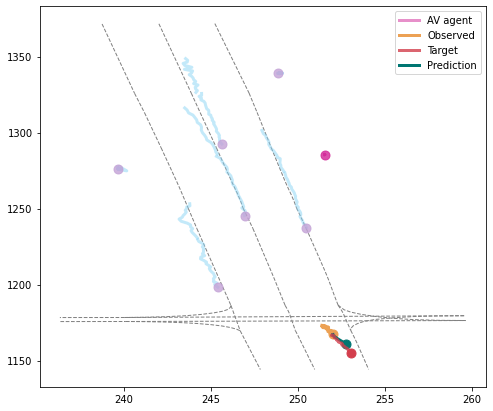

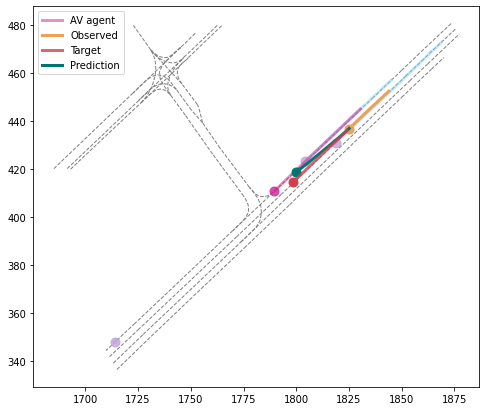

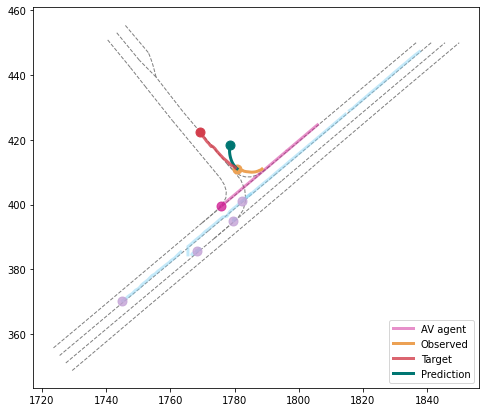

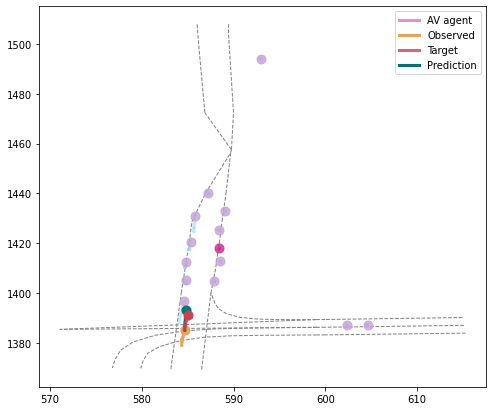

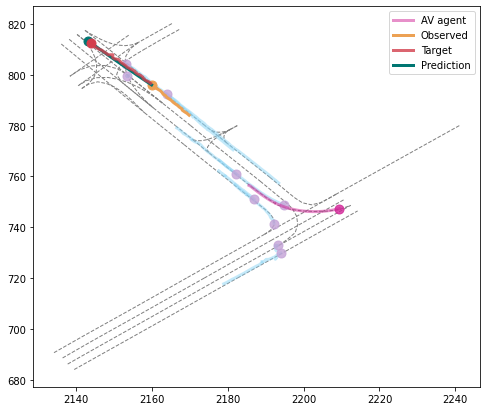

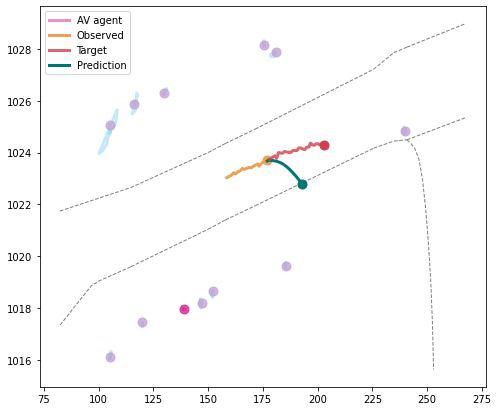

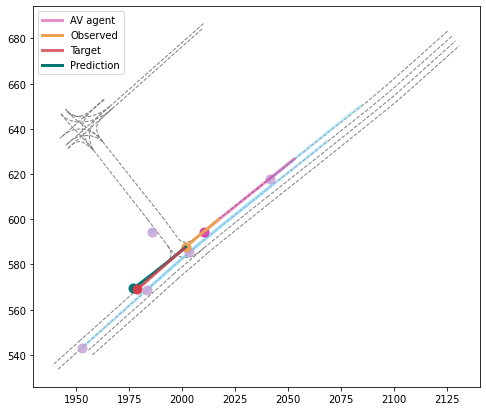

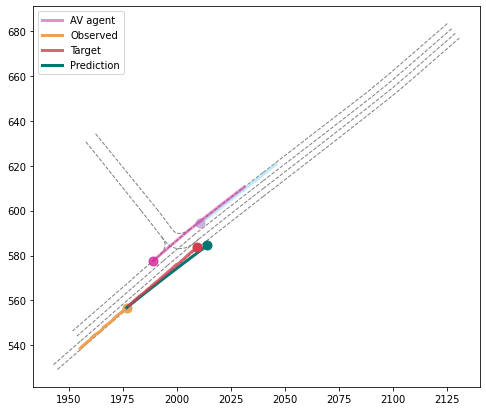

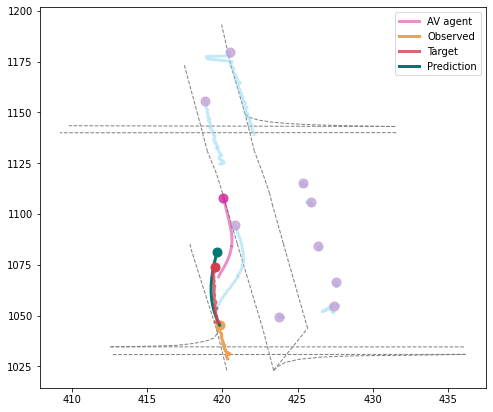

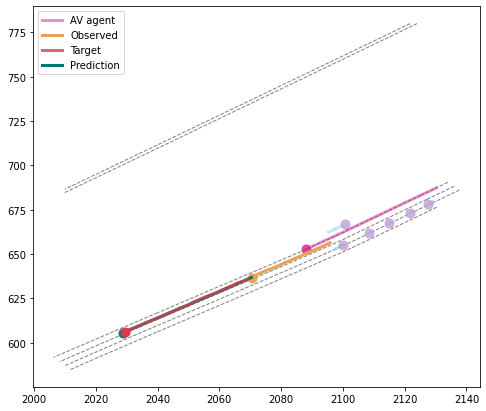

In [11]:
for i in range(32):
    plot_seq(i)

In [13]:
# Model validation

dataiter = iter(test_loader)
output_all = {}
output_all_repeated = {}
counter = 0

test_size=len(argoverse_test)

for test_i in range (len(argoverse_test)):
    
    batch = dataiter.next()
    
    train_agent = batch['train_agent']
    neighbour = batch['neighbour']
    av = batch['av']
    seq_path = batch['seq_path']
    seq_id = batch['indexes']
    Rs = batch['rotation']
    ts = batch['translation']

    obs_traj = train_agent[0].unsqueeze(0)
    obs_traj = torch.cat((obs_traj, av[0].unsqueeze(0)),0)
    obs_traj = torch.cat((obs_traj, neighbour[0]),0)
    
    ped_count = obs_traj.shape[0]
    seq_start_end = [[0, ped_count]] # last number excluded

    for i in range(1, len(neighbour)):
        obs_traj = torch.cat((obs_traj, train_agent[i].unsqueeze(0)), 0)
        obs_traj = torch.cat((obs_traj, av[i].unsqueeze(0)),0)
        obs_traj = torch.cat((obs_traj, neighbour[i]), 0)

        seq_start_end.append([ped_count, obs_traj.shape[0]])

        num_peds_considered = obs_traj.shape[0] - ped_count
        ped_count = obs_traj.shape[0]

    obs_traj_rel = torch.zeros(obs_traj.shape)
    obs_traj_rel[:,1:,:] = obs_traj[:,1:,:] -  obs_traj[:,:-1,:]    

    seq_start_end = torch.tensor(seq_start_end)

    obs_traj = obs_traj.transpose_(0,1).cuda() 
    obs_traj_rel = obs_traj_rel.transpose_(0,1).cuda() 
    ################################################################

    pred_traj_fake_rel = generator(obs_traj, obs_traj_rel, seq_start_end)
    pred_traj_fake = relative_to_abs(pred_traj_fake_rel, obs_traj[-1])
    
    pred_traj_fake_ = pred_traj_fake.cpu().detach().numpy()
    
    idx = int(seq_path[0][41:-4])
    
    # To do : clean this
    single_output = np.expand_dims(np.swapaxes(pred_traj_fake_,0,1)[0], axis = 0)
    single_output = relativeToAbsolute(single_output, Rs[0], ts[0])
    
    output_all[idx] = single_output
    output_all_repeated[idx] = np.repeat(output_all[idx], 6, axis=0)
    
    print(counter)
    counter+=1
    
# Get data to CPU
# obs_traj_ = np.array(obs_traj.cpu())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705


5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345


6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986


8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625


10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
1022

11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
1158

12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
1295

14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
1432

15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
1569

16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
1706

18261
18262
18263
18264
18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
1842

19629
19630
19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
1979

20999
21000
21001
21002
21003
21004
21005
21006
21007
21008
21009
21010
21011
21012
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
2116

22368
22369
22370
22371
22372
22373
22374
22375
22376
22377
22378
22379
22380
22381
22382
22383
22384
22385
22386
22387
22388
22389
22390
22391
22392
22393
22394
22395
22396
22397
22398
22399
22400
22401
22402
22403
22404
22405
22406
22407
22408
22409
22410
22411
22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
2253

23736
23737
23738
23739
23740
23741
23742
23743
23744
23745
23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
2390

25105
25106
25107
25108
25109
25110
25111
25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
2527

26474
26475
26476
26477
26478
26479
26480
26481
26482
26483
26484
26485
26486
26487
26488
26489
26490
26491
26492
26493
26494
26495
26496
26497
26498
26499
26500
26501
26502
26503
26504
26505
26506
26507
26508
26509
26510
26511
26512
26513
26514
26515
26516
26517
26518
26519
26520
26521
26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
2664

27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
2800

29206
29207
29208
29209
29210
29211
29212
29213
29214
29215
29216
29217
29218
29219
29220
29221
29222
29223
29224
29225
29226
29227
29228
29229
29230
29231
29232
29233
29234
29235
29236
29237
29238
29239
29240
29241
29242
29243
29244
29245
29246
29247
29248
29249
29250
29251
29252
29253
29254
29255
29256
29257
29258
29259
29260
29261
29262
29263
29264
29265
29266
29267
29268
29269
29270
29271
29272
29273
29274
29275
29276
29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
2937

30572
30573
30574
30575
30576
30577
30578
30579
30580
30581
30582
30583
30584
30585
30586
30587
30588
30589
30590
30591
30592
30593
30594
30595
30596
30597
30598
30599
30600
30601
30602
30603
30604
30605
30606
30607
30608
30609
30610
30611
30612
30613
30614
30615
30616
30617
30618
30619
30620
30621
30622
30623
30624
30625
30626
30627
30628
30629
30630
30631
30632
30633
30634
30635
30636
30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
3073

31938
31939
31940
31941
31942
31943
31944
31945
31946
31947
31948
31949
31950
31951
31952
31953
31954
31955
31956
31957
31958
31959
31960
31961
31962
31963
31964
31965
31966
31967
31968
31969
31970
31971
31972
31973
31974
31975
31976
31977
31978
31979
31980
31981
31982
31983
31984
31985
31986
31987
31988
31989
31990
31991
31992
31993
31994
31995
31996
31997
31998
31999
32000
32001
32002
32003
32004
32005
32006
32007
32008
32009
32010
32011
32012
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
3210

33306
33307
33308
33309
33310
33311
33312
33313
33314
33315
33316
33317
33318
33319
33320
33321
33322
33323
33324
33325
33326
33327
33328
33329
33330
33331
33332
33333
33334
33335
33336
33337
33338
33339
33340
33341
33342
33343
33344
33345
33346
33347
33348
33349
33350
33351
33352
33353
33354
33355
33356
33357
33358
33359
33360
33361
33362
33363
33364
33365
33366
33367
33368
33369
33370
33371
33372
33373
33374
33375
33376
33377
33378
33379
33380
33381
33382
33383
33384
33385
33386
33387
33388
33389
33390
33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
3347

34673
34674
34675
34676
34677
34678
34679
34680
34681
34682
34683
34684
34685
34686
34687
34688
34689
34690
34691
34692
34693
34694
34695
34696
34697
34698
34699
34700
34701
34702
34703
34704
34705
34706
34707
34708
34709
34710
34711
34712
34713
34714
34715
34716
34717
34718
34719
34720
34721
34722
34723
34724
34725
34726
34727
34728
34729
34730
34731
34732
34733
34734
34735
34736
34737
34738
34739
34740
34741
34742
34743
34744
34745
34746
34747
34748
34749
34750
34751
34752
34753
34754
34755
34756
34757
34758
34759
34760
34761
34762
34763
34764
34765
34766
34767
34768
34769
34770
34771
34772
34773
34774
34775
34776
34777
34778
34779
34780
34781
34782
34783
34784
34785
34786
34787
34788
34789
34790
34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
34801
34802
34803
34804
34805
34806
34807
34808
34809
34810
34811
34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
3483

36043
36044
36045
36046
36047
36048
36049
36050
36051
36052
36053
36054
36055
36056
36057
36058
36059
36060
36061
36062
36063
36064
36065
36066
36067
36068
36069
36070
36071
36072
36073
36074
36075
36076
36077
36078
36079
36080
36081
36082
36083
36084
36085
36086
36087
36088
36089
36090
36091
36092
36093
36094
36095
36096
36097
36098
36099
36100
36101
36102
36103
36104
36105
36106
36107
36108
36109
36110
36111
36112
36113
36114
36115
36116
36117
36118
36119
36120
36121
36122
36123
36124
36125
36126
36127
36128
36129
36130
36131
36132
36133
36134
36135
36136
36137
36138
36139
36140
36141
36142
36143
36144
36145
36146
36147
36148
36149
36150
36151
36152
36153
36154
36155
36156
36157
36158
36159
36160
36161
36162
36163
36164
36165
36166
36167
36168
36169
36170
36171
36172
36173
36174
36175
36176
36177
36178
36179
36180
36181
36182
36183
36184
36185
36186
36187
36188
36189
36190
36191
36192
36193
36194
36195
36196
36197
36198
36199
36200
36201
36202
36203
36204
36205
36206
36207
36208
3620

37413
37414
37415
37416
37417
37418
37419
37420
37421
37422
37423
37424
37425
37426
37427
37428
37429
37430
37431
37432
37433
37434
37435
37436
37437
37438
37439
37440
37441
37442
37443
37444
37445
37446
37447
37448
37449
37450
37451
37452
37453
37454
37455
37456
37457
37458
37459
37460
37461
37462
37463
37464
37465
37466
37467
37468
37469
37470
37471
37472
37473
37474
37475
37476
37477
37478
37479
37480
37481
37482
37483
37484
37485
37486
37487
37488
37489
37490
37491
37492
37493
37494
37495
37496
37497
37498
37499
37500
37501
37502
37503
37504
37505
37506
37507
37508
37509
37510
37511
37512
37513
37514
37515
37516
37517
37518
37519
37520
37521
37522
37523
37524
37525
37526
37527
37528
37529
37530
37531
37532
37533
37534
37535
37536
37537
37538
37539
37540
37541
37542
37543
37544
37545
37546
37547
37548
37549
37550
37551
37552
37553
37554
37555
37556
37557
37558
37559
37560
37561
37562
37563
37564
37565
37566
37567
37568
37569
37570
37571
37572
37573
37574
37575
37576
37577
37578
3757

38779
38780
38781
38782
38783
38784
38785
38786
38787
38788
38789
38790
38791
38792
38793
38794
38795
38796
38797
38798
38799
38800
38801
38802
38803
38804
38805
38806
38807
38808
38809
38810
38811
38812
38813
38814
38815
38816
38817
38818
38819
38820
38821
38822
38823
38824
38825
38826
38827
38828
38829
38830
38831
38832
38833
38834
38835
38836
38837
38838
38839
38840
38841
38842
38843
38844
38845
38846
38847
38848
38849
38850
38851
38852
38853
38854
38855
38856
38857
38858
38859
38860
38861
38862
38863
38864
38865
38866
38867
38868
38869
38870
38871
38872
38873
38874
38875
38876
38877
38878
38879
38880
38881
38882
38883
38884
38885
38886
38887
38888
38889
38890
38891
38892
38893
38894
38895
38896
38897
38898
38899
38900
38901
38902
38903
38904
38905
38906
38907
38908
38909
38910
38911
38912
38913
38914
38915
38916
38917
38918
38919
38920
38921
38922
38923
38924
38925
38926
38927
38928
38929
38930
38931
38932
38933
38934
38935
38936
38937
38938
38939
38940
38941
38942
38943
38944
3894

40145
40146
40147
40148
40149
40150
40151
40152
40153
40154
40155
40156
40157
40158
40159
40160
40161
40162
40163
40164
40165
40166
40167
40168
40169
40170
40171
40172
40173
40174
40175
40176
40177
40178
40179
40180
40181
40182
40183
40184
40185
40186
40187
40188
40189
40190
40191
40192
40193
40194
40195
40196
40197
40198
40199
40200
40201
40202
40203
40204
40205
40206
40207
40208
40209
40210
40211
40212
40213
40214
40215
40216
40217
40218
40219
40220
40221
40222
40223
40224
40225
40226
40227
40228
40229
40230
40231
40232
40233
40234
40235
40236
40237
40238
40239
40240
40241
40242
40243
40244
40245
40246
40247
40248
40249
40250
40251
40252
40253
40254
40255
40256
40257
40258
40259
40260
40261
40262
40263
40264
40265
40266
40267
40268
40269
40270
40271
40272
40273
40274
40275
40276
40277
40278
40279
40280
40281
40282
40283
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
40298
40299
40300
40301
40302
40303
40304
40305
40306
40307
40308
40309
40310
4031

41512
41513
41514
41515
41516
41517
41518
41519
41520
41521
41522
41523
41524
41525
41526
41527
41528
41529
41530
41531
41532
41533
41534
41535
41536
41537
41538
41539
41540
41541
41542
41543
41544
41545
41546
41547
41548
41549
41550
41551
41552
41553
41554
41555
41556
41557
41558
41559
41560
41561
41562
41563
41564
41565
41566
41567
41568
41569
41570
41571
41572
41573
41574
41575
41576
41577
41578
41579
41580
41581
41582
41583
41584
41585
41586
41587
41588
41589
41590
41591
41592
41593
41594
41595
41596
41597
41598
41599
41600
41601
41602
41603
41604
41605
41606
41607
41608
41609
41610
41611
41612
41613
41614
41615
41616
41617
41618
41619
41620
41621
41622
41623
41624
41625
41626
41627
41628
41629
41630
41631
41632
41633
41634
41635
41636
41637
41638
41639
41640
41641
41642
41643
41644
41645
41646
41647
41648
41649
41650
41651
41652
41653
41654
41655
41656
41657
41658
41659
41660
41661
41662
41663
41664
41665
41666
41667
41668
41669
41670
41671
41672
41673
41674
41675
41676
41677
4167

42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
42903
42904
42905
42906
42907
42908
42909
42910
42911
42912
42913
42914
42915
42916
42917
42918
42919
42920
42921
42922
42923
42924
42925
42926
42927
42928
42929
42930
42931
42932
42933
42934
42935
42936
42937
42938
42939
42940
42941
42942
42943
42944
42945
42946
42947
42948
42949
42950
42951
42952
42953
42954
42955
42956
42957
42958
42959
42960
42961
42962
42963
42964
42965
42966
42967
42968
42969
42970
42971
42972
42973
42974
42975
42976
42977
42978
42979
42980
42981
42982
42983
42984
42985
42986
42987
42988
42989
42990
42991
42992
42993
42994
42995
42996
42997
42998
42999
43000
43001
43002
43003
43004
43005
43006
43007
43008
43009
43010
43011
43012
43013
43014
43015
43016
43017
43018
43019
43020
43021
43022
43023
43024
43025
43026
43027
43028
43029
43030
43031
43032
43033
43034
43035
43036
43037
43038
43039
43040
43041
43042
43043
43044
43045
4304

44246
44247
44248
44249
44250
44251
44252
44253
44254
44255
44256
44257
44258
44259
44260
44261
44262
44263
44264
44265
44266
44267
44268
44269
44270
44271
44272
44273
44274
44275
44276
44277
44278
44279
44280
44281
44282
44283
44284
44285
44286
44287
44288
44289
44290
44291
44292
44293
44294
44295
44296
44297
44298
44299
44300
44301
44302
44303
44304
44305
44306
44307
44308
44309
44310
44311
44312
44313
44314
44315
44316
44317
44318
44319
44320
44321
44322
44323
44324
44325
44326
44327
44328
44329
44330
44331
44332
44333
44334
44335
44336
44337
44338
44339
44340
44341
44342
44343
44344
44345
44346
44347
44348
44349
44350
44351
44352
44353
44354
44355
44356
44357
44358
44359
44360
44361
44362
44363
44364
44365
44366
44367
44368
44369
44370
44371
44372
44373
44374
44375
44376
44377
44378
44379
44380
44381
44382
44383
44384
44385
44386
44387
44388
44389
44390
44391
44392
44393
44394
44395
44396
44397
44398
44399
44400
44401
44402
44403
44404
44405
44406
44407
44408
44409
44410
44411
4441

45613
45614
45615
45616
45617
45618
45619
45620
45621
45622
45623
45624
45625
45626
45627
45628
45629
45630
45631
45632
45633
45634
45635
45636
45637
45638
45639
45640
45641
45642
45643
45644
45645
45646
45647
45648
45649
45650
45651
45652
45653
45654
45655
45656
45657
45658
45659
45660
45661
45662
45663
45664
45665
45666
45667
45668
45669
45670
45671
45672
45673
45674
45675
45676
45677
45678
45679
45680
45681
45682
45683
45684
45685
45686
45687
45688
45689
45690
45691
45692
45693
45694
45695
45696
45697
45698
45699
45700
45701
45702
45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
45729
45730
45731
45732
45733
45734
45735
45736
45737
45738
45739
45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
4577

46980
46981
46982
46983
46984
46985
46986
46987
46988
46989
46990
46991
46992
46993
46994
46995
46996
46997
46998
46999
47000
47001
47002
47003
47004
47005
47006
47007
47008
47009
47010
47011
47012
47013
47014
47015
47016
47017
47018
47019
47020
47021
47022
47023
47024
47025
47026
47027
47028
47029
47030
47031
47032
47033
47034
47035
47036
47037
47038
47039
47040
47041
47042
47043
47044
47045
47046
47047
47048
47049
47050
47051
47052
47053
47054
47055
47056
47057
47058
47059
47060
47061
47062
47063
47064
47065
47066
47067
47068
47069
47070
47071
47072
47073
47074
47075
47076
47077
47078
47079
47080
47081
47082
47083
47084
47085
47086
47087
47088
47089
47090
47091
47092
47093
47094
47095
47096
47097
47098
47099
47100
47101
47102
47103
47104
47105
47106
47107
47108
47109
47110
47111
47112
47113
47114
47115
47116
47117
47118
47119
47120
47121
47122
47123
47124
47125
47126
47127
47128
47129
47130
47131
47132
47133
47134
47135
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
4714

48350
48351
48352
48353
48354
48355
48356
48357
48358
48359
48360
48361
48362
48363
48364
48365
48366
48367
48368
48369
48370
48371
48372
48373
48374
48375
48376
48377
48378
48379
48380
48381
48382
48383
48384
48385
48386
48387
48388
48389
48390
48391
48392
48393
48394
48395
48396
48397
48398
48399
48400
48401
48402
48403
48404
48405
48406
48407
48408
48409
48410
48411
48412
48413
48414
48415
48416
48417
48418
48419
48420
48421
48422
48423
48424
48425
48426
48427
48428
48429
48430
48431
48432
48433
48434
48435
48436
48437
48438
48439
48440
48441
48442
48443
48444
48445
48446
48447
48448
48449
48450
48451
48452
48453
48454
48455
48456
48457
48458
48459
48460
48461
48462
48463
48464
48465
48466
48467
48468
48469
48470
48471
48472
48473
48474
48475
48476
48477
48478
48479
48480
48481
48482
48483
48484
48485
48486
48487
48488
48489
48490
48491
48492
48493
48494
48495
48496
48497
48498
48499
48500
48501
48502
48503
48504
48505
48506
48507
48508
48509
48510
48511
48512
48513
48514
48515
4851

49718
49719
49720
49721
49722
49723
49724
49725
49726
49727
49728
49729
49730
49731
49732
49733
49734
49735
49736
49737
49738
49739
49740
49741
49742
49743
49744
49745
49746
49747
49748
49749
49750
49751
49752
49753
49754
49755
49756
49757
49758
49759
49760
49761
49762
49763
49764
49765
49766
49767
49768
49769
49770
49771
49772
49773
49774
49775
49776
49777
49778
49779
49780
49781
49782
49783
49784
49785
49786
49787
49788
49789
49790
49791
49792
49793
49794
49795
49796
49797
49798
49799
49800
49801
49802
49803
49804
49805
49806
49807
49808
49809
49810
49811
49812
49813
49814
49815
49816
49817
49818
49819
49820
49821
49822
49823
49824
49825
49826
49827
49828
49829
49830
49831
49832
49833
49834
49835
49836
49837
49838
49839
49840
49841
49842
49843
49844
49845
49846
49847
49848
49849
49850
49851
49852
49853
49854
49855
49856
49857
49858
49859
49860
49861
49862
49863
49864
49865
49866
49867
49868
49869
49870
49871
49872
49873
49874
49875
49876
49877
49878
49879
49880
49881
49882
49883
4988

51085
51086
51087
51088
51089
51090
51091
51092
51093
51094
51095
51096
51097
51098
51099
51100
51101
51102
51103
51104
51105
51106
51107
51108
51109
51110
51111
51112
51113
51114
51115
51116
51117
51118
51119
51120
51121
51122
51123
51124
51125
51126
51127
51128
51129
51130
51131
51132
51133
51134
51135
51136
51137
51138
51139
51140
51141
51142
51143
51144
51145
51146
51147
51148
51149
51150
51151
51152
51153
51154
51155
51156
51157
51158
51159
51160
51161
51162
51163
51164
51165
51166
51167
51168
51169
51170
51171
51172
51173
51174
51175
51176
51177
51178
51179
51180
51181
51182
51183
51184
51185
51186
51187
51188
51189
51190
51191
51192
51193
51194
51195
51196
51197
51198
51199
51200
51201
51202
51203
51204
51205
51206
51207
51208
51209
51210
51211
51212
51213
51214
51215
51216
51217
51218
51219
51220
51221
51222
51223
51224
51225
51226
51227
51228
51229
51230
51231
51232
51233
51234
51235
51236
51237
51238
51239
51240
51241
51242
51243
51244
51245
51246
51247
51248
51249
51250
5125

52456
52457
52458
52459
52460
52461
52462
52463
52464
52465
52466
52467
52468
52469
52470
52471
52472
52473
52474
52475
52476
52477
52478
52479
52480
52481
52482
52483
52484
52485
52486
52487
52488
52489
52490
52491
52492
52493
52494
52495
52496
52497
52498
52499
52500
52501
52502
52503
52504
52505
52506
52507
52508
52509
52510
52511
52512
52513
52514
52515
52516
52517
52518
52519
52520
52521
52522
52523
52524
52525
52526
52527
52528
52529
52530
52531
52532
52533
52534
52535
52536
52537
52538
52539
52540
52541
52542
52543
52544
52545
52546
52547
52548
52549
52550
52551
52552
52553
52554
52555
52556
52557
52558
52559
52560
52561
52562
52563
52564
52565
52566
52567
52568
52569
52570
52571
52572
52573
52574
52575
52576
52577
52578
52579
52580
52581
52582
52583
52584
52585
52586
52587
52588
52589
52590
52591
52592
52593
52594
52595
52596
52597
52598
52599
52600
52601
52602
52603
52604
52605
52606
52607
52608
52609
52610
52611
52612
52613
52614
52615
52616
52617
52618
52619
52620
52621
5262

53822
53823
53824
53825
53826
53827
53828
53829
53830
53831
53832
53833
53834
53835
53836
53837
53838
53839
53840
53841
53842
53843
53844
53845
53846
53847
53848
53849
53850
53851
53852
53853
53854
53855
53856
53857
53858
53859
53860
53861
53862
53863
53864
53865
53866
53867
53868
53869
53870
53871
53872
53873
53874
53875
53876
53877
53878
53879
53880
53881
53882
53883
53884
53885
53886
53887
53888
53889
53890
53891
53892
53893
53894
53895
53896
53897
53898
53899
53900
53901
53902
53903
53904
53905
53906
53907
53908
53909
53910
53911
53912
53913
53914
53915
53916
53917
53918
53919
53920
53921
53922
53923
53924
53925
53926
53927
53928
53929
53930
53931
53932
53933
53934
53935
53936
53937
53938
53939
53940
53941
53942
53943
53944
53945
53946
53947
53948
53949
53950
53951
53952
53953
53954
53955
53956
53957
53958
53959
53960
53961
53962
53963
53964
53965
53966
53967
53968
53969
53970
53971
53972
53973
53974
53975
53976
53977
53978
53979
53980
53981
53982
53983
53984
53985
53986
53987
5398

55188
55189
55190
55191
55192
55193
55194
55195
55196
55197
55198
55199
55200
55201
55202
55203
55204
55205
55206
55207
55208
55209
55210
55211
55212
55213
55214
55215
55216
55217
55218
55219
55220
55221
55222
55223
55224
55225
55226
55227
55228
55229
55230
55231
55232
55233
55234
55235
55236
55237
55238
55239
55240
55241
55242
55243
55244
55245
55246
55247
55248
55249
55250
55251
55252
55253
55254
55255
55256
55257
55258
55259
55260
55261
55262
55263
55264
55265
55266
55267
55268
55269
55270
55271
55272
55273
55274
55275
55276
55277
55278
55279
55280
55281
55282
55283
55284
55285
55286
55287
55288
55289
55290
55291
55292
55293
55294
55295
55296
55297
55298
55299
55300
55301
55302
55303
55304
55305
55306
55307
55308
55309
55310
55311
55312
55313
55314
55315
55316
55317
55318
55319
55320
55321
55322
55323
55324
55325
55326
55327
55328
55329
55330
55331
55332
55333
55334
55335
55336
55337
55338
55339
55340
55341
55342
55343
55344
55345
55346
55347
55348
55349
55350
55351
55352
55353
5535

56559
56560
56561
56562
56563
56564
56565
56566
56567
56568
56569
56570
56571
56572
56573
56574
56575
56576
56577
56578
56579
56580
56581
56582
56583
56584
56585
56586
56587
56588
56589
56590
56591
56592
56593
56594
56595
56596
56597
56598
56599
56600
56601
56602
56603
56604
56605
56606
56607
56608
56609
56610
56611
56612
56613
56614
56615
56616
56617
56618
56619
56620
56621
56622
56623
56624
56625
56626
56627
56628
56629
56630
56631
56632
56633
56634
56635
56636
56637
56638
56639
56640
56641
56642
56643
56644
56645
56646
56647
56648
56649
56650
56651
56652
56653
56654
56655
56656
56657
56658
56659
56660
56661
56662
56663
56664
56665
56666
56667
56668
56669
56670
56671
56672
56673
56674
56675
56676
56677
56678
56679
56680
56681
56682
56683
56684
56685
56686
56687
56688
56689
56690
56691
56692
56693
56694
56695
56696
56697
56698
56699
56700
56701
56702
56703
56704
56705
56706
56707
56708
56709
56710
56711
56712
56713
56714
56715
56716
56717
56718
56719
56720
56721
56722
56723
56724
5672

57925
57926
57927
57928
57929
57930
57931
57932
57933
57934
57935
57936
57937
57938
57939
57940
57941
57942
57943
57944
57945
57946
57947
57948
57949
57950
57951
57952
57953
57954
57955
57956
57957
57958
57959
57960
57961
57962
57963
57964
57965
57966
57967
57968
57969
57970
57971
57972
57973
57974
57975
57976
57977
57978
57979
57980
57981
57982
57983
57984
57985
57986
57987
57988
57989
57990
57991
57992
57993
57994
57995
57996
57997
57998
57999
58000
58001
58002
58003
58004
58005
58006
58007
58008
58009
58010
58011
58012
58013
58014
58015
58016
58017
58018
58019
58020
58021
58022
58023
58024
58025
58026
58027
58028
58029
58030
58031
58032
58033
58034
58035
58036
58037
58038
58039
58040
58041
58042
58043
58044
58045
58046
58047
58048
58049
58050
58051
58052
58053
58054
58055
58056
58057
58058
58059
58060
58061
58062
58063
58064
58065
58066
58067
58068
58069
58070
58071
58072
58073
58074
58075
58076
58077
58078
58079
58080
58081
58082
58083
58084
58085
58086
58087
58088
58089
58090
5809

59295
59296
59297
59298
59299
59300
59301
59302
59303
59304
59305
59306
59307
59308
59309
59310
59311
59312
59313
59314
59315
59316
59317
59318
59319
59320
59321
59322
59323
59324
59325
59326
59327
59328
59329
59330
59331
59332
59333
59334
59335
59336
59337
59338
59339
59340
59341
59342
59343
59344
59345
59346
59347
59348
59349
59350
59351
59352
59353
59354
59355
59356
59357
59358
59359
59360
59361
59362
59363
59364
59365
59366
59367
59368
59369
59370
59371
59372
59373
59374
59375
59376
59377
59378
59379
59380
59381
59382
59383
59384
59385
59386
59387
59388
59389
59390
59391
59392
59393
59394
59395
59396
59397
59398
59399
59400
59401
59402
59403
59404
59405
59406
59407
59408
59409
59410
59411
59412
59413
59414
59415
59416
59417
59418
59419
59420
59421
59422
59423
59424
59425
59426
59427
59428
59429
59430
59431
59432
59433
59434
59435
59436
59437
59438
59439
59440
59441
59442
59443
59444
59445
59446
59447
59448
59449
59450
59451
59452
59453
59454
59455
59456
59457
59458
59459
59460
5946

60664
60665
60666
60667
60668
60669
60670
60671
60672
60673
60674
60675
60676
60677
60678
60679
60680
60681
60682
60683
60684
60685
60686
60687
60688
60689
60690
60691
60692
60693
60694
60695
60696
60697
60698
60699
60700
60701
60702
60703
60704
60705
60706
60707
60708
60709
60710
60711
60712
60713
60714
60715
60716
60717
60718
60719
60720
60721
60722
60723
60724
60725
60726
60727
60728
60729
60730
60731
60732
60733
60734
60735
60736
60737
60738
60739
60740
60741
60742
60743
60744
60745
60746
60747
60748
60749
60750
60751
60752
60753
60754
60755
60756
60757
60758
60759
60760
60761
60762
60763
60764
60765
60766
60767
60768
60769
60770
60771
60772
60773
60774
60775
60776
60777
60778
60779
60780
60781
60782
60783
60784
60785
60786
60787
60788
60789
60790
60791
60792
60793
60794
60795
60796
60797
60798
60799
60800
60801
60802
60803
60804
60805
60806
60807
60808
60809
60810
60811
60812
60813
60814
60815
60816
60817
60818
60819
60820
60821
60822
60823
60824
60825
60826
60827
60828
60829
6083

62031
62032
62033
62034
62035
62036
62037
62038
62039
62040
62041
62042
62043
62044
62045
62046
62047
62048
62049
62050
62051
62052
62053
62054
62055
62056
62057
62058
62059
62060
62061
62062
62063
62064
62065
62066
62067
62068
62069
62070
62071
62072
62073
62074
62075
62076
62077
62078
62079
62080
62081
62082
62083
62084
62085
62086
62087
62088
62089
62090
62091
62092
62093
62094
62095
62096
62097
62098
62099
62100
62101
62102
62103
62104
62105
62106
62107
62108
62109
62110
62111
62112
62113
62114
62115
62116
62117
62118
62119
62120
62121
62122
62123
62124
62125
62126
62127
62128
62129
62130
62131
62132
62133
62134
62135
62136
62137
62138
62139
62140
62141
62142
62143
62144
62145
62146
62147
62148
62149
62150
62151
62152
62153
62154
62155
62156
62157
62158
62159
62160
62161
62162
62163
62164
62165
62166
62167
62168
62169
62170
62171
62172
62173
62174
62175
62176
62177
62178
62179
62180
62181
62182
62183
62184
62185
62186
62187
62188
62189
62190
62191
62192
62193
62194
62195
62196
6219

63399
63400
63401
63402
63403
63404
63405
63406
63407
63408
63409
63410
63411
63412
63413
63414
63415
63416
63417
63418
63419
63420
63421
63422
63423
63424
63425
63426
63427
63428
63429
63430
63431
63432
63433
63434
63435
63436
63437
63438
63439
63440
63441
63442
63443
63444
63445
63446
63447
63448
63449
63450
63451
63452
63453
63454
63455
63456
63457
63458
63459
63460
63461
63462
63463
63464
63465
63466
63467
63468
63469
63470
63471
63472
63473
63474
63475
63476
63477
63478
63479
63480
63481
63482
63483
63484
63485
63486
63487
63488
63489
63490
63491
63492
63493
63494
63495
63496
63497
63498
63499
63500
63501
63502
63503
63504
63505
63506
63507
63508
63509
63510
63511
63512
63513
63514
63515
63516
63517
63518
63519
63520
63521
63522
63523
63524
63525
63526
63527
63528
63529
63530
63531
63532
63533
63534
63535
63536
63537
63538
63539
63540
63541
63542
63543
63544
63545
63546
63547
63548
63549
63550
63551
63552
63553
63554
63555
63556
63557
63558
63559
63560
63561
63562
63563
63564
6356

64765
64766
64767
64768
64769
64770
64771
64772
64773
64774
64775
64776
64777
64778
64779
64780
64781
64782
64783
64784
64785
64786
64787
64788
64789
64790
64791
64792
64793
64794
64795
64796
64797
64798
64799
64800
64801
64802
64803
64804
64805
64806
64807
64808
64809
64810
64811
64812
64813
64814
64815
64816
64817
64818
64819
64820
64821
64822
64823
64824
64825
64826
64827
64828
64829
64830
64831
64832
64833
64834
64835
64836
64837
64838
64839
64840
64841
64842
64843
64844
64845
64846
64847
64848
64849
64850
64851
64852
64853
64854
64855
64856
64857
64858
64859
64860
64861
64862
64863
64864
64865
64866
64867
64868
64869
64870
64871
64872
64873
64874
64875
64876
64877
64878
64879
64880
64881
64882
64883
64884
64885
64886
64887
64888
64889
64890
64891
64892
64893
64894
64895
64896
64897
64898
64899
64900
64901
64902
64903
64904
64905
64906
64907
64908
64909
64910
64911
64912
64913
64914
64915
64916
64917
64918
64919
64920
64921
64922
64923
64924
64925
64926
64927
64928
64929
64930
6493

66132
66133
66134
66135
66136
66137
66138
66139
66140
66141
66142
66143
66144
66145
66146
66147
66148
66149
66150
66151
66152
66153
66154
66155
66156
66157
66158
66159
66160
66161
66162
66163
66164
66165
66166
66167
66168
66169
66170
66171
66172
66173
66174
66175
66176
66177
66178
66179
66180
66181
66182
66183
66184
66185
66186
66187
66188
66189
66190
66191
66192
66193
66194
66195
66196
66197
66198
66199
66200
66201
66202
66203
66204
66205
66206
66207
66208
66209
66210
66211
66212
66213
66214
66215
66216
66217
66218
66219
66220
66221
66222
66223
66224
66225
66226
66227
66228
66229
66230
66231
66232
66233
66234
66235
66236
66237
66238
66239
66240
66241
66242
66243
66244
66245
66246
66247
66248
66249
66250
66251
66252
66253
66254
66255
66256
66257
66258
66259
66260
66261
66262
66263
66264
66265
66266
66267
66268
66269
66270
66271
66272
66273
66274
66275
66276
66277
66278
66279
66280
66281
66282
66283
66284
66285
66286
66287
66288
66289
66290
66291
66292
66293
66294
66295
66296
66297
6629

67502
67503
67504
67505
67506
67507
67508
67509
67510
67511
67512
67513
67514
67515
67516
67517
67518
67519
67520
67521
67522
67523
67524
67525
67526
67527
67528
67529
67530
67531
67532
67533
67534
67535
67536
67537
67538
67539
67540
67541
67542
67543
67544
67545
67546
67547
67548
67549
67550
67551
67552
67553
67554
67555
67556
67557
67558
67559
67560
67561
67562
67563
67564
67565
67566
67567
67568
67569
67570
67571
67572
67573
67574
67575
67576
67577
67578
67579
67580
67581
67582
67583
67584
67585
67586
67587
67588
67589
67590
67591
67592
67593
67594
67595
67596
67597
67598
67599
67600
67601
67602
67603
67604
67605
67606
67607
67608
67609
67610
67611
67612
67613
67614
67615
67616
67617
67618
67619
67620
67621
67622
67623
67624
67625
67626
67627
67628
67629
67630
67631
67632
67633
67634
67635
67636
67637
67638
67639
67640
67641
67642
67643
67644
67645
67646
67647
67648
67649
67650
67651
67652
67653
67654
67655
67656
67657
67658
67659
67660
67661
67662
67663
67664
67665
67666
67667
6766

68872
68873
68874
68875
68876
68877
68878
68879
68880
68881
68882
68883
68884
68885
68886
68887
68888
68889
68890
68891
68892
68893
68894
68895
68896
68897
68898
68899
68900
68901
68902
68903
68904
68905
68906
68907
68908
68909
68910
68911
68912
68913
68914
68915
68916
68917
68918
68919
68920
68921
68922
68923
68924
68925
68926
68927
68928
68929
68930
68931
68932
68933
68934
68935
68936
68937
68938
68939
68940
68941
68942
68943
68944
68945
68946
68947
68948
68949
68950
68951
68952
68953
68954
68955
68956
68957
68958
68959
68960
68961
68962
68963
68964
68965
68966
68967
68968
68969
68970
68971
68972
68973
68974
68975
68976
68977
68978
68979
68980
68981
68982
68983
68984
68985
68986
68987
68988
68989
68990
68991
68992
68993
68994
68995
68996
68997
68998
68999
69000
69001
69002
69003
69004
69005
69006
69007
69008
69009
69010
69011
69012
69013
69014
69015
69016
69017
69018
69019
69020
69021
69022
69023
69024
69025
69026
69027
69028
69029
69030
69031
69032
69033
69034
69035
69036
69037
6903

70238
70239
70240
70241
70242
70243
70244
70245
70246
70247
70248
70249
70250
70251
70252
70253
70254
70255
70256
70257
70258
70259
70260
70261
70262
70263
70264
70265
70266
70267
70268
70269
70270
70271
70272
70273
70274
70275
70276
70277
70278
70279
70280
70281
70282
70283
70284
70285
70286
70287
70288
70289
70290
70291
70292
70293
70294
70295
70296
70297
70298
70299
70300
70301
70302
70303
70304
70305
70306
70307
70308
70309
70310
70311
70312
70313
70314
70315
70316
70317
70318
70319
70320
70321
70322
70323
70324
70325
70326
70327
70328
70329
70330
70331
70332
70333
70334
70335
70336
70337
70338
70339
70340
70341
70342
70343
70344
70345
70346
70347
70348
70349
70350
70351
70352
70353
70354
70355
70356
70357
70358
70359
70360
70361
70362
70363
70364
70365
70366
70367
70368
70369
70370
70371
70372
70373
70374
70375
70376
70377
70378
70379
70380
70381
70382
70383
70384
70385
70386
70387
70388
70389
70390
70391
70392
70393
70394
70395
70396
70397
70398
70399
70400
70401
70402
70403
7040

71607
71608
71609
71610
71611
71612
71613
71614
71615
71616
71617
71618
71619
71620
71621
71622
71623
71624
71625
71626
71627
71628
71629
71630
71631
71632
71633
71634
71635
71636
71637
71638
71639
71640
71641
71642
71643
71644
71645
71646
71647
71648
71649
71650
71651
71652
71653
71654
71655
71656
71657
71658
71659
71660
71661
71662
71663
71664
71665
71666
71667
71668
71669
71670
71671
71672
71673
71674
71675
71676
71677
71678
71679
71680
71681
71682
71683
71684
71685
71686
71687
71688
71689
71690
71691
71692
71693
71694
71695
71696
71697
71698
71699
71700
71701
71702
71703
71704
71705
71706
71707
71708
71709
71710
71711
71712
71713
71714
71715
71716
71717
71718
71719
71720
71721
71722
71723
71724
71725
71726
71727
71728
71729
71730
71731
71732
71733
71734
71735
71736
71737
71738
71739
71740
71741
71742
71743
71744
71745
71746
71747
71748
71749
71750
71751
71752
71753
71754
71755
71756
71757
71758
71759
71760
71761
71762
71763
71764
71765
71766
71767
71768
71769
71770
71771
71772
7177

72973
72974
72975
72976
72977
72978
72979
72980
72981
72982
72983
72984
72985
72986
72987
72988
72989
72990
72991
72992
72993
72994
72995
72996
72997
72998
72999
73000
73001
73002
73003
73004
73005
73006
73007
73008
73009
73010
73011
73012
73013
73014
73015
73016
73017
73018
73019
73020
73021
73022
73023
73024
73025
73026
73027
73028
73029
73030
73031
73032
73033
73034
73035
73036
73037
73038
73039
73040
73041
73042
73043
73044
73045
73046
73047
73048
73049
73050
73051
73052
73053
73054
73055
73056
73057
73058
73059
73060
73061
73062
73063
73064
73065
73066
73067
73068
73069
73070
73071
73072
73073
73074
73075
73076
73077
73078
73079
73080
73081
73082
73083
73084
73085
73086
73087
73088
73089
73090
73091
73092
73093
73094
73095
73096
73097
73098
73099
73100
73101
73102
73103
73104
73105
73106
73107
73108
73109
73110
73111
73112
73113
73114
73115
73116
73117
73118
73119
73120
73121
73122
73123
73124
73125
73126
73127
73128
73129
73130
73131
73132
73133
73134
73135
73136
73137
73138
7313

74341
74342
74343
74344
74345
74346
74347
74348
74349
74350
74351
74352
74353
74354
74355
74356
74357
74358
74359
74360
74361
74362
74363
74364
74365
74366
74367
74368
74369
74370
74371
74372
74373
74374
74375
74376
74377
74378
74379
74380
74381
74382
74383
74384
74385
74386
74387
74388
74389
74390
74391
74392
74393
74394
74395
74396
74397
74398
74399
74400
74401
74402
74403
74404
74405
74406
74407
74408
74409
74410
74411
74412
74413
74414
74415
74416
74417
74418
74419
74420
74421
74422
74423
74424
74425
74426
74427
74428
74429
74430
74431
74432
74433
74434
74435
74436
74437
74438
74439
74440
74441
74442
74443
74444
74445
74446
74447
74448
74449
74450
74451
74452
74453
74454
74455
74456
74457
74458
74459
74460
74461
74462
74463
74464
74465
74466
74467
74468
74469
74470
74471
74472
74473
74474
74475
74476
74477
74478
74479
74480
74481
74482
74483
74484
74485
74486
74487
74488
74489
74490
74491
74492
74493
74494
74495
74496
74497
74498
74499
74500
74501
74502
74503
74504
74505
74506
7450

75709
75710
75711
75712
75713
75714
75715
75716
75717
75718
75719
75720
75721
75722
75723
75724
75725
75726
75727
75728
75729
75730
75731
75732
75733
75734
75735
75736
75737
75738
75739
75740
75741
75742
75743
75744
75745
75746
75747
75748
75749
75750
75751
75752
75753
75754
75755
75756
75757
75758
75759
75760
75761
75762
75763
75764
75765
75766
75767
75768
75769
75770
75771
75772
75773
75774
75775
75776
75777
75778
75779
75780
75781
75782
75783
75784
75785
75786
75787
75788
75789
75790
75791
75792
75793
75794
75795
75796
75797
75798
75799
75800
75801
75802
75803
75804
75805
75806
75807
75808
75809
75810
75811
75812
75813
75814
75815
75816
75817
75818
75819
75820
75821
75822
75823
75824
75825
75826
75827
75828
75829
75830
75831
75832
75833
75834
75835
75836
75837
75838
75839
75840
75841
75842
75843
75844
75845
75846
75847
75848
75849
75850
75851
75852
75853
75854
75855
75856
75857
75858
75859
75860
75861
75862
75863
75864
75865
75866
75867
75868
75869
75870
75871
75872
75873
75874
7587

77079
77080
77081
77082
77083
77084
77085
77086
77087
77088
77089
77090
77091
77092
77093
77094
77095
77096
77097
77098
77099
77100
77101
77102
77103
77104
77105
77106
77107
77108
77109
77110
77111
77112
77113
77114
77115
77116
77117
77118
77119
77120
77121
77122
77123
77124
77125
77126
77127
77128
77129
77130
77131
77132
77133
77134
77135
77136
77137
77138
77139
77140
77141
77142
77143
77144
77145
77146
77147
77148
77149
77150
77151
77152
77153
77154
77155
77156
77157
77158
77159
77160
77161
77162
77163
77164
77165
77166
77167
77168
77169
77170
77171
77172
77173
77174
77175
77176
77177
77178
77179
77180
77181
77182
77183
77184
77185
77186
77187
77188
77189
77190
77191
77192
77193
77194
77195
77196
77197
77198
77199
77200
77201
77202
77203
77204
77205
77206
77207
77208
77209
77210
77211
77212
77213
77214
77215
77216
77217
77218
77219
77220
77221
77222
77223
77224
77225
77226
77227
77228
77229
77230
77231
77232
77233
77234
77235
77236
77237
77238
77239
77240
77241
77242
77243
77244
7724

In [18]:
output_all_repeated[56283].shape

(6, 30, 2)

In [15]:
from argoverse.evaluation.competition_util import generate_forecasting_h5

output_path = '../../sgan/scripts/temp/'
generate_forecasting_h5(output_all_repeated, output_path) #this might take awhile

78143/78143